#### Подключение библиотек


In [1]:
#IMPORT LIBS 

#download
import glob
import natsort
import zipfile
import os
import cv2 as cv

#numpy
import numpy as np
import numpy.linalg as LA
import numpy.testing as npt

#torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


#sklearn
from sklearn.preprocessing import normalize

#skimage
#!pip install scikit-image
from skimage import data, transform, filters, io, color, util
from skimage.util import img_as_float, img_as_ubyte
from skimage.transform import AffineTransform, warp, rescale, rotate, resize
from skimage.io import imread, imsave, imread_collection
from skimage.filters import farid, sobel, threshold_li, gaussian, median
from skimage.morphology import disk, binary_dilation, binary_erosion, area_opening, binary_closing
from skimage.feature import register_translation

#scipy
from scipy.ndimage import fourier_shift

#parallel
import joblib
from joblib import Parallel, delayed

#display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import colorsys
from PIL import Image, ImageEnhance

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import mean_squared_error
import time

/home/anabatsh/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
device

device(type='cpu')

In [3]:
torch.set_printoptions(precision=4)

### Загрузка данных

In [4]:
import torch
import torchvision.transforms as transforms

class ToTensor():
    def __init__(self):
        self.tr = transforms.ToTensor()

    def __call__(self, img):
        return self.tr(img)

class DeNoise():

    def __call__(self, img):
        img = img.to(device)
        fft = torch.fft.rfft2(img)
        fft = torch.fft.irfft2(fft)
        return fft

class ToDevice():
    def __init__(self, device):
        self.device = device

    def __call__(self, img):
        img = img.to(self.device)
        return img

class Normalize():
    def __call__(self, img):
        max = torch.max(img)
        min = torch.min(img)
        mean = (max - min) / 2
        std = max - mean

        img = (img - mean) / std
        img = (img * 127.5 + 127.5)
        return img

class Compose():
    def __init__(self, *args):
        self.compose = transforms.Compose(*args)

    def __call__(self, img):
        return self.compose(img)

In [5]:
import torch
import cv2
from torch.nn.functional import conv2d, conv_transpose2d

def find_pixel_shift(base_img, move_img, conv_kernel, rad=1):
    best_score, results = None, (0, 0)
    
    base_h, base_w = base_img.shape[-2:]
    move_h, move_w = move_img.shape[-2:]
    h = max(base_h, move_h)
    w  = max(base_w, move_w)
    
    THRESHOLD = 100
    if h > THRESHOLD or w > THRESHOLD:
        (tmp_i, tmp_j), rad = find_pixel_shift(conv2d(base_img, conv_kernel, stride=3), 
                                               conv2d(move_img, conv_kernel, stride=3), 
                                               conv_kernel, rad)
        
        tmp_i *= 3; tmp_j *= 3;
        
        l_i, l_j = tmp_i-1, tmp_j-1
        r_i, r_j = tmp_i+1, tmp_j+1
        
    else:
        l_i, l_j = -rad, -rad
        r_i, r_j = rad, rad
        
    rad += 1
#     print(rad, l_i, r_i+1, l_j, r_j+1)
    for i in range(l_i, r_i + 1):
        for j in range(l_j, r_j + 1):
            
            a, b, c, d = rad+i, -rad+i, rad+j, -rad+j 
            b = b if b else h
            d = d if d else w
            MSE_score = torch.mean(torch.square(
                base_img[0][0][rad:-rad, rad:-rad] -
                move_img[0][0][a:b, c:d]
            ))
            if best_score == None or best_score > MSE_score:
                best_score = MSE_score
                results = (i, j)
    return results, 3 * (rad - 1)

def find_subpixel_shift(base_img, move_img, conv_kernel):
    
    (y, x), rad = find_pixel_shift(base_img, move_img, conv_kernel)
    
    h, w = base_img.shape[-2:]
    res = torch.empty(5, device=device)
    rad = rad // 3 + 1
#     print(f'shift: {y, x}, rad: {rad}')
    for res_ind, (i, j) in enumerate(((y-1, x), (y, x-1), (y, x), (y, x+1), (y+1, x))):
        a, b, c, d = rad+i, -rad+i, rad+j, -rad+j 
        b = b if b else h
        d = d if d else w
#         print(f'i: {i}, j: {j}, a, b, c, d: {a, b, c, d}')
        res[res_ind] = torch.mean(torch.square(
            base_img[0][0][rad:-rad, rad:-rad] -
            move_img[0][0][a:b, c:d]
        ))
    u, l, c, r, d = res
    dy = (d - u) / (2 * (d + u - 2 * c))
    dx = (r - l) / (2 * (l + r - 2 * c))
    
    return y-dy.item(), x-dx.item()

def pixel_shift(img, shift):
    y, x = shift
    h, w = img.shape[-2:]
    
    if y != 0:
        a, b, c, d, e, f = (0, -y, y, h, -y, h) if y > 0 else (-y, h, 0, y, 0, -y)
        img[..., a:b, 0:w] = img[..., c:d, 0:w].detach().clone()
        print
        img[..., e:f, 0:w] = 0

    if x != 0:
        a, b, c, d, e, f = (0, -x, x, w, -x, w) if x > 0 else (-x, w, 0, x, 0, -x)
        img[..., 0:h, a:b] = img[..., 0:h, c:d].detach().clone()
        img[..., 0:h, e:f] = 0

    return img
            
def subpixel_shift(img, d_shift):
    dy, dx = d_shift
    c_dy, c_dx = abs(dy), abs(dx)
    h, w = img.shape[-2:]
    
    if dy != 0.:
        a, b, c, d = (0, -1, 1, h) if dy > 0. else (1, h, 0, -1)
        S = img[..., a:b, 0:w] * (1 - c_dy)
        S = S + img[..., c:d, 0:w] * c_dy
        img[..., a:b, 0:w] = S
        
    if dx != 0.:
        a, b, c, d = (0, -1, 1, w) if dx > 0. else (1, w, 0, -1)       
        S = img[..., 0:h, a:b] * (1 - c_dx)
        S = S + img[..., 0:h, c:d] * c_dx
        img[..., 0:h, a:b] = S

    return img

def special_subpixel_shift(img, shift):    
    y_dy, x_dx = shift
    y, x = int(y_dy), int(x_dx)
    dy, dx = y_dy - y, x_dx - x
    
    img = subpixel_shift(img, (dy, dx))
    img = pixel_shift(img, (y, x))
    return img

In [6]:
class ConvStab_Operator():
    
    def __init__(self, base_img, steps=3):
        
        self.base_img = base_img

        self.steps = steps + 1
        self.kernel = torch.ones(1,1,3,3).to(device) * 1/9
        self.base_conv = self.convolve(self.base_img)
    
    def convolve(self, img):
        conv = []
        
        for step in range(self.steps):
            if step:
                img = conv2d(img, self.kernel, stride=3)
            conv.append(img)
            
        return conv
    
    
    def stabilize(self, img):
        
        move_conv = self.convolve(img)
        
        best_score = None
        result = (0, 0)
        
        for step in range(self.steps)[::-1]:

            rad = 3 ** (3 - step) + 1
            
            res_i, res_j = result
            
            for i in range(res_i-1, res_j+2):
                for j in range(res_i-1, res_j+2):

                    a, b, c, d = rad+i, -rad+i, rad+j, -rad+j 
                    
                    MSE_score = torch.mean(torch.square(
                        self.base_conv[step][0][0][rad:-rad, rad:-rad] -
                        move_conv[step][0][0][a:b, c:d]
                    ))
                    
#                     print(f'({rad}), s: {i, j} score: {MSE_score.item():.3f}')
                    
                    if best_score == None or best_score > MSE_score:
                        best_score = MSE_score
                        result = (i*3, j*3) if step else (i, j)
                        
        corr = [0] * 5
        y, x = result
        
#         for idx, (i, j) in enumerate(((y-1, x), (y, x-1), (y, x), (y, x+1), (y+1, x))):
#             a, b, c, d = rad+i, -rad+i, rad+j, -rad+j 

#             corr[idx] = torch.mean(torch.square(
#                 self.base_conv[step][0][0][rad:-rad, rad:-rad] -
#                 move_conv[step][0][0][a:b, c:d]
#             ))
        
#         u, l, c, r, d = corr
#         dy = (d - u) / (2 * (d + u - 2 * c))
#         dx = (r - l) / (2 * (l + r - 2 * c))
    
#         y, x = y-dy.item(), x-dx.item()
#         print(y, x)
        pad_ = [0] * 4
        if y > 0:
            pad_[3] = y
        if y < 0:
            pad_[2] = -y
        if x > 0:
            pad_[1] = x
        if x < 0:
            pad_[0] = -x
        
        img = torch.nn.functional.pad(img, pad_)
        if y > 0:
            img = img[..., y:, :]
        if y < 0:
            img = img[..., :y, :]
            
        if x > 0:
            img = img[..., :, x:]
        if x < 0:
            img = img[..., :, :x]
            
        return img

# Видос

In [7]:
import numpy as np
import cv2 as cv

#------Open the video

video_name = 13

cap = cv.VideoCapture(f'video/{video_name}.mp4')
cap_width = int(cap.get(3))
cap_height = int(cap.get(4))

fourcc = cv.VideoWriter_fourcc('M','J','P','G')
out = cv.VideoWriter(f'result/{video_name}.mp4', fourcc, 20.0, (cap_width, cap_height), isColor=False)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

#------Read the video

transform = Compose([ToTensor(), 
                     ToDevice(device),
                     Normalize()
                    ])

cs = None

def generator(val):
    while val:
        yield

for i, _ in enumerate(tqdm(generator(cap.isOpened()))):
# while(cap.isOpened()):
    ret, img = cap.read()
    if ret == True:
        
        #------Main cycle
        
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = transform(img).unsqueeze(0)
        
        if cs is not None:
            img = cs.stabilize(img)
            pic_to_save = img.cpu()[0][0].numpy().astype(np.uint8)        
            out.write(pic_to_save)
#             cv.imshow('Frame', pic_to_save)
            imsave(f'result/{i}.png', pic_to_save)

        else:
            cs = ConvStab_Operator(img, 3)

        #------End cycle
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
        if i > 10:
            break
    else:
        break  

#------Close the video

cap.release()
out.release()

# cv2.destroyAllWindows()

In [414]:
import numpy as np
import cv2 as cv

#------Open the video

video_name = 3

cap = cv.VideoCapture(f'video/{video_name}.mp4')
cap_width = int(cap.get(3))
cap_height = int(cap.get(4))

fourcc = cv.VideoWriter_fourcc('M','J','P','G')
out = cv.VideoWriter(f'result/{video_name}.mp4', fourcc, 20.0, (cap_width, cap_height), isColor=True)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

#------Read the video

transform = Compose([ToTensor(), 
                     ToDevice(device),
                     Normalize()
                    ])
prev_img = None
mask_img = None
mask = None
conv_kernel = torch.ones(1,1,3,3).to(device) * 1/9

i = 1
while(cap.isOpened()):
    ret, curr_img = cap.read()
    if ret == True:
        
        #------Main cycle
        
        curr_img = cv.cvtColor(curr_img, cv.COLOR_BGR2GRAY)
        curr_img = transform(curr_img).unsqueeze(0)
        
        if prev_img is not None:
            shift, _ = find_pixel_shift(prev_img, curr_img, conv_kernel)
            print(shift)
            curr_img = special_subpixel_shift(curr_img, shift)
            
            vasc += abs(curr_img - mask_img) / 255
            pic_to_save = abs(curr_img - mask_img) * (curr_img > 0.) * (mask_img > 0.)
            
            if i % 30 == 0:
                mask = (vasc > torch.quantile(vasc, 0.8)).to(torch.float32)
                mask = conv2d(mask, conv_kernel, stride=1, padding=1) == 1.
                vasc[...] = 0

            if mask is not None:
                pic_to_save = curr_img[0].repeat(3, 1, 1)
                pic_to_save[0] *= 0.6
                pic_to_save[1] *= 0.6
                pic_to_save[2][~mask[0][0]] *= 0.6
                pic_to_save = pic_to_save.transpose(0, 1).transpose(1, 2).cpu().numpy().astype(np.uint8)        
                out.write(pic_to_save)
                cv.imshow('Frame', pic_to_save)

                
            mask_img = curr_img
#             prev_img = curr_img
    
        else:
            prev_img = curr_img
            mask_img = prev_img
            vasc = torch.zeros_like(prev_img)

        #------End cycle
        i += 1
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    else:
        break  

#------Close the video

cap.release()
out.release()

cv2.destroyAllWindows()

(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(0, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 2)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 1)
(1, 1)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(2, 2)
(1, 2)
(2, 2)
(1, 2)
(2, 2)
(1, 2)

RuntimeError: The size of tensor a (340) must match the size of tensor b (0) at non-singleton dimension 0

In [7]:
prev_img = transform(images[0]).unsqueeze(0)
mask_img = prev_img
vasc = torch.zeros_like(prev_img)
mask = None
pics_to_save = []

conv_kernel = torch.ones(1,1,3,3).to(device) * 1/9

for i, curr_img in enumerate(tqdm(images[1:], desc='step')):
    curr_img = transform(curr_img).unsqueeze(0)
    shift = find_subpixel_shift(prev_img, curr_img, conv_kernel)
    curr_img = special_subpixel_shift(curr_img, shift)
    
#     vasc += abs(curr_img - mask_img) / 255
    pic_to_save = abs(curr_img - mask_img) * (curr_img > 0.) * (mask_img > 0.)
#     if (i + 1) % 100 == 0:
#         mask = (vasc > torch.quantile(vasc, 0.8)).to(torch.float32)
#         mask = conv2d(mask, conv_kernel, stride=1, padding=1) == 1.
# #         plt.figure(figsize=(10, 10))
# #         plt.imshow(mask.cpu()[0][0])
# #         plt.show()
#         vasc[...] = 0

        
#     if mask is not None:
#         pic_to_save = curr_img[0].repeat(3, 1, 1)
#         pic_to_save[0] *= 0.2
#         pic_to_save[1] *= 0.2
#         pic_to_save[2][~mask[0][0]] *= 0.2
#         pic_to_save = pic_to_save.transpose(0, 1).transpose(1, 2).cpu().numpy().astype(np.uint8)        
#         pics_to_save.append(pic_to_save)

#     pic_to_save = curr_img[0][0].cpu().numpy().astype(np.uint8)        
    pics_to_save.append(pic_to_save[0][0].cpu().numpy().astype(np.uint8))
    mask_img = curr_img

#     prev_img = curr_img

step:   0%|          | 0/499 [00:00<?, ?it/s]

# Open PIV again

In [8]:
def corr_clarification(R, shift, device, up_c=100):

    im2pi = 1j * 2 * torch.pi

    up_c_part = int(up_c / 2)
    dfshift = up_c_part - shift * up_c
    shape = R.shape[1:]

    for i in (1, 0):
        kernel = torch.arange(1.5 * up_c).to(device)[:, None] - dfshift[i]
        fft_req = torch.fft.fftfreq(shape[i], up_c, dtype=torch.float64, device=device)
        kernel = kernel * fft_req
        kernel = torch.exp(-im2pi * kernel).to(device)
        R = torch.tensordot(kernel, R, dims=([1], [-1]))

    R = R.transpose(2, 0).transpose(1, 2)
    sub_shift =  unravel_ind(R.conj()).to(device) - up_c_part
    sub_shift = sub_shift / up_c

    return sub_shift


def unravel_ind(corr):
    w = corr.shape[-1]
    max_ind = torch.argmax(torch.abs(corr))
    shift = torch.tensor([max_ind // w, max_ind % w])
    return shift

def phase_cross_correlation(base_img, mov_img, device, up_c=100):

    base_fft = torch.fft.fftn(base_img)
    mov_fft = torch.fft.fftn(mov_img)

    R = (base_fft * mov_fft.conj()).type(torch.complex128)
    corr = torch.fft.ifftn(R)

    shape = corr.shape[1:]
    shape = torch.tensor(shape, device=device)
    shift =  unravel_ind(corr).to(device)
    midpoints = torch.fix(shape / 2)
    shift[shift > midpoints] -= shape[shift > midpoints]

    sub_shift = corr_clarification(R.conj(), shift, device, up_c=up_c)

    shift = shift + sub_shift

    return shift

In [9]:
def get_field_shape(h, w, window_size, overlap):
    
    k = window_size - overlap
    
    f_h = (h - window_size) // k + 1
    f_w = (w - window_size) // k + 1
    
    return f_h, f_w
    
def get_coordinates(h, w, window_size, overlap):
    
    k = window_size - overlap

    f_h, f_w = get_field_shape(h, w, window_size, overlap)
    
    i = torch.arange(f_h)
    j = torch.arange(f_w)
    
    y = i * k
    x = j * k
    
    II, JJ = torch.meshgrid(i, j)
    YY, XX = torch.meshgrid(y, x)
    
    IJYX = torch.stack((II, JJ, YY, XX), axis=-1).view(-1, 4)
    return IJYX

In [10]:
def split(img, window_size, overlap):
    h, w = img.shape[-2:]
    s = window_size
    return [img[..., x:x+s, y:y+s] for x, y in get_coordinates(h, w, window_size, overlap)]

In [11]:
images = [imread(file) for file in glob.glob('result/*.png')]

In [12]:
img_a = transform(images[0]).unsqueeze(0)
img_b = transform(images[1]).unsqueeze(0)

h, w = img_b.shape[-2:]
window_size = 11
overlap = 5
conv_kernel = torch.ones(1,1,3,3).to(device) * 1/9

f_h, f_w = get_field_shape(h, w, window_size, overlap)
field = torch.zeros(f_h, f_w, 2)

for i, j, x, y in get_coordinates(h, w, window_size, overlap):
    s = window_size
    w_shift = find_subpixel_shift(img_a[..., x:x+s, y:y+s], 
                                  img_b[..., x:x+s, y:y+s], 
                                  conv_kernel=conv_kernel)
    field[i][j] = torch.tensor(w_shift)

In [13]:
mag = torch.norm(field, dim=-1)

In [17]:
angle = torch.arctan(field[...,0] / field[...,1])

In [53]:
max_mag = torch.quantile(mag, 0.9)
min_mag = torch.quantile(mag, 0.8)
mag_ = torch.clip(mag, min_mag, max_mag)
mag_bin = mag_ > 1.

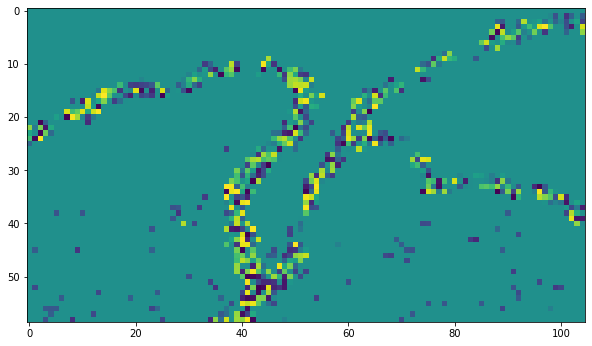

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(mag_bin * angle)

In [89]:


def display_vector_field(field):
    a = np.loadtxt(filename)
    # parse
    x, y, u, v, mask = a[:, 0], a[:, 1], a[:, 2], a[:, 3], a[:, 4]


    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    if on_img is True:  # plot a background image
        im = imread(image_name)
        im = negative(im)  # plot negative of the image for more clarity
        # imsave('neg.tif', im)
        # im = imread('neg.tif')
        xmax = np.amax(x) + window_size / (2 * scaling_factor)
        ymax = np.amax(y) + window_size / (2 * scaling_factor)
        ax.imshow(im, cmap="Greys_r", extent=[0.0, xmax, 0.0, ymax])
        # plt.draw()

    invalid = mask.astype("bool")  
    valid = ~invalid


    ax.quiver(
        x[invalid], y[invalid], u[invalid], v[invalid], color="r", width=width, **kw)
    ax.quiver(x[valid], y[valid], u[valid], v[valid], color="b", width=width,**kw)
    
    # if on_img is False:
    #     ax.invert_yaxis()
    
    ax.set_aspect(1.)
    # fig.canvas.set_window_title('Vector field, '+str(np.count_nonzero(invalid))+' wrong vectors')

    plt.show()

    return fig, ax

tensor(3496.7852)